# Step 1: Data Collection, Processing, and Visualization

## 1.1. Collecting YEN Data:

In [3]:
import yfinance as yf
import pandas as pd

# Downloading JPY/USD data
jpy_usd = yf.download('JPYUSD=X', start='2021-03-10', end='2024-08-30', interval='1d')

# Ensure the index is a datetime format and set the frequency to daily
jpy_usd.index = pd.to_datetime(jpy_usd.index)
jpy_usd = jpy_usd.asfreq('D')  # Sets the frequency to daily

# Display the first few rows
print(jpy_usd.head())

# Save to CSV
jpy_usd.to_csv('JPY_USD_data.csv')

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2021-03-10  0.009211  0.009230  0.009181  0.009210   0.009210     0.0
2021-03-11  0.009222  0.009228  0.009191  0.009222   0.009222     0.0
2021-03-12  0.009210  0.009215  0.009162  0.009212   0.009212     0.0
2021-03-13       NaN       NaN       NaN       NaN        NaN     NaN
2021-03-14       NaN       NaN       NaN       NaN        NaN     NaN


## 1.2. Collecting GYEN Data:

In [4]:
# Download GYEN/USD data
gyen_usd = yf.download('GYEN-USD', start='2021-03-10', end='2024-08-30', interval='1d')

# Ensure the index is a datetime format and set the frequency to daily
gyen_usd.index = pd.to_datetime(gyen_usd.index)
gyen_usd = gyen_usd.asfreq('D')  # Sets the frequency to daily

# Display the first few rows
print(gyen_usd.head())

# Save to CSV
gyen_usd.to_csv('GYEN_USD_data.csv')

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2021-03-10  0.009226  0.009231  0.009224  0.009229   0.009229   38233
2021-03-11  0.009228  0.009232  0.009191  0.009212   0.009212  308571
2021-03-12  0.009210  0.009215  0.009155  0.009179   0.009179   37345
2021-03-13  0.009179  0.009187  0.009165  0.009178   0.009178  201012
2021-03-14  0.009178  0.009189  0.009168  0.009168   0.009168   49557


## 1.3. Handling Missing Data

In [5]:
# Check for missing values
print('Missing values in JPY data:\n', jpy_usd.isna().sum())
print('Missing values in GYEN data:\n', gyen_usd.isna().sum())

# Handling Missing Data with Forward Fill Method
jpy_usd.ffill(inplace=True)  # Forward fill missing values
gyen_usd.ffill(inplace=True)  # Forward fill missing values

Missing values in JPY data:
 Open         362
High         362
Low          362
Close        362
Adj Close    362
Volume       362
dtype: int64
Missing values in GYEN data:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


## 1.4. Data Normalization

Descriptive statistics before scaling:
JPY/USD Close Price - Summary:
count    1269.000000
mean        0.007622
std         0.000947
min         0.006187
25%         0.006804
50%         0.007364
75%         0.008699
max         0.009270
Name: Close, dtype: float64

GYEN/USD Close Price - Summary:
count    1269.000000
mean        0.007606
std         0.001064
min         0.004918
25%         0.006824
50%         0.007351
75%         0.008667
max         0.023436
Name: Close, dtype: float64


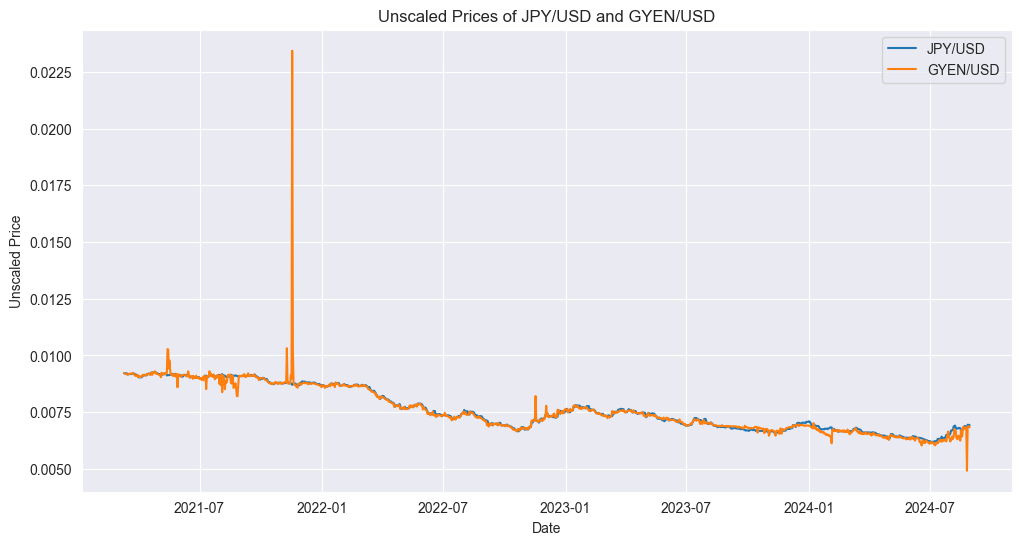

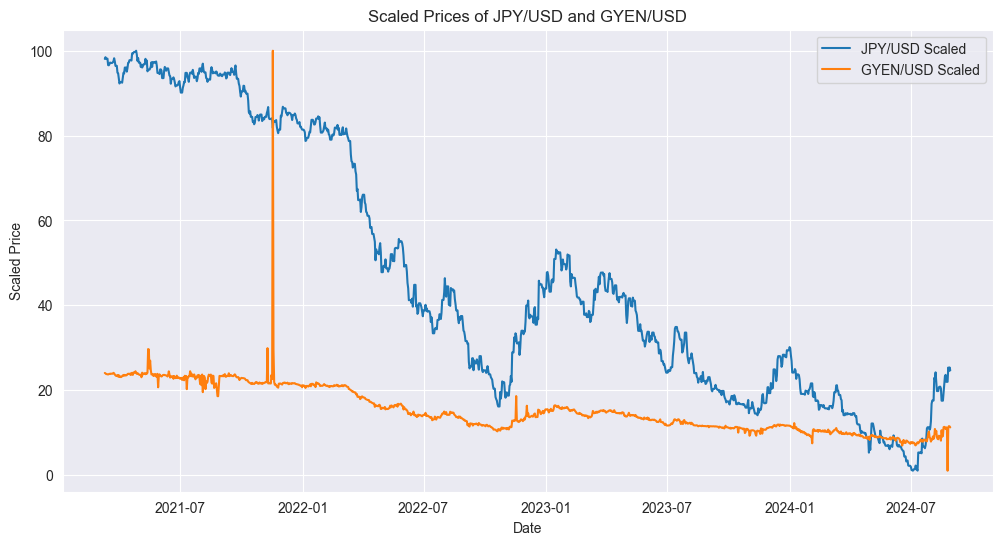


Descriptive statistics after scaling:
JPY/USD Scaled - Summary:
count    1269.000000
mean       47.065345
std        30.421647
min         1.000000
25%        20.806341
50%        38.789514
75%        81.657430
max       100.000000
Name: Close_scaled, dtype: float64

GYEN/USD Scaled - Summary:
count    1269.000000
mean       15.367799
std         5.689218
min         1.000000
25%        11.189759
50%        14.007180
75%        21.042712
max       100.000000
Name: Close_scaled, dtype: float64

Scaled Data - Minimum and Maximum Values:
JPY/USD Scaled - Min: 1.0 Max: 100.0
GYEN/USD Scaled - Min: 1.0 Max: 100.0


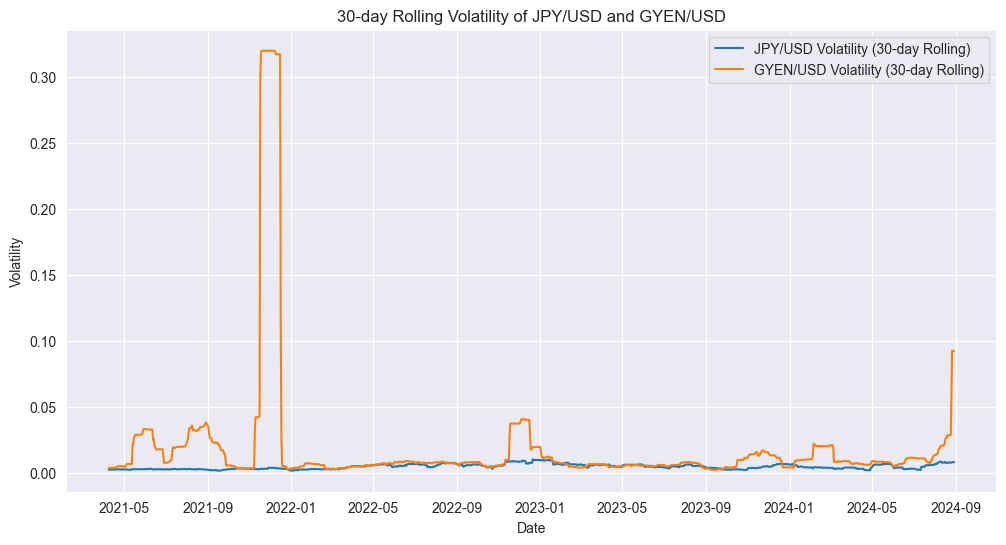

In [10]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate descriptive statistics before scaling
print("Descriptive statistics before scaling:")
print("JPY/USD Close Price - Summary:")
print(jpy_usd['Close'].describe())
print("\nGYEN/USD Close Price - Summary:")
print(gyen_usd['Close'].describe())

# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(jpy_usd.index, jpy_usd['Close'], label='JPY/USD')
plt.plot(gyen_usd.index, gyen_usd['Close'], label='GYEN/USD')
plt.title('Unscaled Prices of JPY/USD and GYEN/USD')
plt.xlabel('Date')
plt.ylabel('Unscaled Price')
plt.legend()
plt.show()

# Initialize the scaler
scaler_jpy = MinMaxScaler(feature_range=(1, 100))
scaler_gyen = MinMaxScaler(feature_range=(1, 100))

# Apply Min-Max Scaling
jpy_usd['Close_scaled'] = scaler_jpy.fit_transform(jpy_usd[['Close']])
gyen_usd['Close_scaled'] = scaler_gyen.fit_transform(gyen_usd[['Close']])

# Plot scaled data
plt.figure(figsize=(12, 6))
plt.plot(jpy_usd.index, jpy_usd['Close_scaled'], label='JPY/USD Scaled')
plt.plot(gyen_usd.index, gyen_usd['Close_scaled'], label='GYEN/USD Scaled')
plt.title('Scaled Prices of JPY/USD and GYEN/USD')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

# Calculate descriptive statistics after scaling
print("\nDescriptive statistics after scaling:")
print("JPY/USD Scaled - Summary:")
print(jpy_usd['Close_scaled'].describe())
print("\nGYEN/USD Scaled - Summary:")
print(gyen_usd['Close_scaled'].describe())

# Check for potential anomalies in the scaling range
print("\nScaled Data - Minimum and Maximum Values:")
print("JPY/USD Scaled - Min:", jpy_usd['Close_scaled'].min(), "Max:", jpy_usd['Close_scaled'].max())
print("GYEN/USD Scaled - Min:", gyen_usd['Close_scaled'].min(), "Max:", gyen_usd['Close_scaled'].max())

# Calculate rolling volatility (30-day rolling window)
jpy_usd['Rolling_Volatility'] = jpy_usd['Close'].pct_change().rolling(window=30).std()
gyen_usd['Rolling_Volatility'] = gyen_usd['Close'].pct_change().rolling(window=30).std()

# Plot rolling volatility
plt.figure(figsize=(12, 6))
plt.plot(jpy_usd.index, jpy_usd['Rolling_Volatility'], label='JPY/USD Volatility (30-day Rolling)')
plt.plot(gyen_usd.index, gyen_usd['Rolling_Volatility'], label='GYEN/USD Volatility (30-day Rolling)')
plt.title('30-day Rolling Volatility of JPY/USD and GYEN/USD')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

## 1.5. Stationarity Check with ADF Test

In [7]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF Test on original and scaled data
adf_result_jpy = adfuller(jpy_usd['Close'].dropna())
adf_result_gyen = adfuller(gyen_usd['Close'].dropna())

print(f'JPY ADF Statistic: {adf_result_jpy[0]}, p-value: {adf_result_jpy[1]}')
print(f'GYEN ADF Statistic: {adf_result_gyen[0]}, p-value: {adf_result_gyen[1]}')

JPY ADF Statistic: -1.5108773621372695, p-value: 0.528123765198089
GYEN ADF Statistic: -1.4686328268009974, p-value: 0.5489672605579607


Findings:

Both the JPY and GYEN ADF statistics are not very negative (only around -1.51 and -1.47, respectively), and the p-values are high (0.52 for JPY and 0.55 for GYEN). These results indicate that the null hypothesis cannot be rejected, meaning both time series are likely non-stationary.

Given that both JPY and GYEN series are non-stationary, we will likely need to difference the data to achieve stationarity before applying the ARIMA model.

So, we run the following processes:

In [8]:
# Applying first differencing for stationarization
jpy_usd['Close_diff'] = jpy_usd['Close'].diff().dropna()
gyen_usd['Close_diff'] = gyen_usd['Close'].diff().dropna()

# Re-running the ADF test on differenced data
adf_result_jpy_diff = adfuller(jpy_usd['Close_diff'].dropna())
adf_result_gyen_diff = adfuller(gyen_usd['Close_diff'].dropna())

print(f'JPY Differenced ADF Statistic: {adf_result_jpy_diff[0]}, p-value: {adf_result_jpy_diff[1]}')
print(f'GYEN Differenced ADF Statistic: {adf_result_gyen_diff[0]}, p-value: {adf_result_gyen_diff[1]}')

JPY Differenced ADF Statistic: -34.52752844078779, p-value: 0.0
GYEN Differenced ADF Statistic: -13.514711724261565, p-value: 2.808952507565943e-25


Findings:

Significantly Negative ADF Statistics: Both ADF statistics are highly negative (-29.62 for JPY and -13.51 for GYEN), indicating strong evidence against the null hypothesis of non-stationarity. The more negative the ADF statistic, the stronger the rejection of the null hypothesis.

Very Low p-values: Both p-values are extremely low (0.0 for JPY and approximately 0.0 for GYEN), which are far below the typical threshold of 0.05. This means there is a very strong rejection of the null hypothesis that the series are non-stationary.

The differenced time series for both JPY and GYEN are now stationary. This means you have successfully transformed the original non-stationary data into a stationary form, which is suitable for ARIMA modeling.

# Step 2: Modeling

## 2.1. ARIMA Modeling (GYEN Data Only)

<Figure size 1000x600 with 0 Axes>

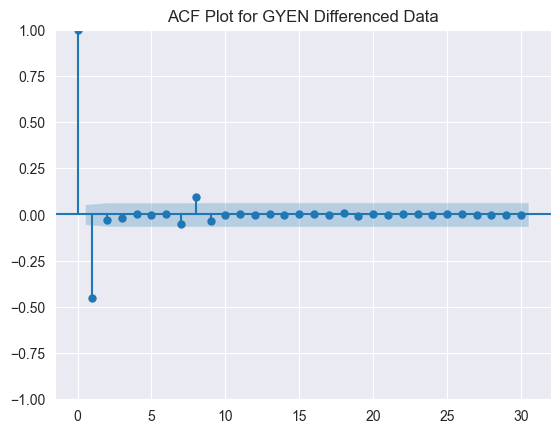

<Figure size 1000x600 with 0 Axes>

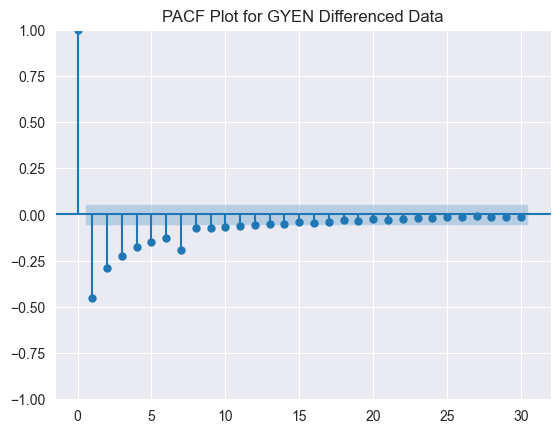

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF for GYEN
plt.figure(figsize=(10, 6))
plot_acf(gyen_usd['Close_diff'].dropna(), lags=30)
plt.title('ACF Plot for GYEN Differenced Data')
plt.show()

# Plot PACF for GYEN
plt.figure(figsize=(10, 6))
plot_pacf(gyen_usd['Close_diff'].dropna(), lags=30)
plt.title('PACF Plot for GYEN Differenced Data')
plt.show()

In [25]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_model = ARIMA(gyen_usd['Close_diff'].dropna(), order=(0, 0, 0))
arima_fit = arima_model.fit()

# Summary of the ARIMA model
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1268
Model:                          ARIMA   Log Likelihood                7673.503
Date:                Sat, 02 Nov 2024   AIC                         -15343.006
Time:                        17:59:59   BIC                         -15332.715
Sample:                    03-11-2021   HQIC                        -15339.140
                         - 08-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.893e-06   1.64e-05     -0.420      0.675   -3.91e-05    2.53e-05
sigma2      3.301e-07   8.09e-10    408.026      0.000    3.29e-07    3.32e-07
Ljung-Box (L1) (Q):                 257.16   Jarque-

Findings:

The PACF values then decrease after lag 1 but remain somewhat elevated up to around lag 2. Although the spike at lag 2 is not as prominent as at lag 1, it is still above the confidence interval, indicating that there might be some correlation extending to two previous lags. This justifies considering an AR(2) model.

The idea is that there might be a direct dependency on the values at both lag 1 and lag 2. While the correlation at lag 2 is weaker than at lag 1, it is still statistically significant (outside the confidence band). This warrants considering an AR(2) model to capture this additional dependence.

There is a need to determine which `p` value might be the most appropriate for this dataset, considering that the significant spikes in the Partial Autocorrelation Function (PACF) plot persist up to approximately lag 8. Try incrementally increasing `p` up to 7 and use information criteria to determine which model might be the most appropriate for this model.


Using Information Criteria to Compare AR(1) vs. AR(2)
Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC):
AIC and BIC are both measures used to compare the goodness of fit of different statistical models while penalizing for model complexity.
Procedure:
Fit multiple AR models (e.g., AR(1), AR(2), etc.).
Calculate the AIC and BIC for each model.
Choose the model with the lowest AIC or BIC. The model with the lowest value strikes the best balance between fit and complexity.

In [10]:
from statsmodels.tsa.arima.model import ARIMA
# 
# # Configure mdoels
# arima_model_ar1 = ARIMA(gyen_usd['Close_diff'].dropna(), order=(1, 1, 1))
# arima_model_ar2 = ARIMA(gyen_usd['Close_diff'].dropna(), order=(2, 1, 1))
# arima_model_ar3 = ARIMA(gyen_usd['Close_diff'].dropna(), order=(3, 1, 1))
# arima_model_ar4 = ARIMA(gyen_usd['Close_diff'].dropna(), order=(4, 1, 1))
# arima_model_ar5 = ARIMA(gyen_usd['Close_diff'].dropna(), order=(5, 1, 1))
# arima_model_ar6 = ARIMA(gyen_usd['Close_diff'].dropna(), order=(6, 1, 1))
# arima_model_ar7 = ARIMA(gyen_usd['Close_diff'].dropna(), order=(7, 1, 1))
# arima_model_ar8 = ARIMA(gyen_usd['Close_diff'].dropna(), order=(8, 1, 1))
# 
# # Fit models
# arima_fit_ar1 = arima_model_ar1.fit()
# arima_fit_ar2 = arima_model_ar2.fit()
# arima_fit_ar3 = arima_model_ar3.fit()
# arima_fit_ar4 = arima_model_ar4.fit()
# arima_fit_ar5 = arima_model_ar5.fit()
# arima_fit_ar6 = arima_model_ar6.fit()
# arima_fit_ar7 = arima_model_ar7.fit()
# arima_fit_ar8 = arima_model_ar8.fit()
# 
# # Compare AIC and BIC
# print(f"AR(1) AIC: {arima_fit_ar1.aic}, BIC: {arima_fit_ar1.bic}")
# print(f"AR(2) AIC: {arima_fit_ar2.aic}, BIC: {arima_fit_ar2.bic}")
# print(f"AR(3) AIC: {arima_fit_ar3.aic}, BIC: {arima_fit_ar3.bic}")
# print(f"AR(4) AIC: {arima_fit_ar4.aic}, BIC: {arima_fit_ar4.bic}")
# print(f"AR(5) AIC: {arima_fit_ar5.aic}, BIC: {arima_fit_ar5.bic}")
# print(f"AR(6) AIC: {arima_fit_ar6.aic}, BIC: {arima_fit_ar6.bic}")
# print(f"AR(7) AIC: {arima_fit_ar7.aic}, BIC: {arima_fit_ar7.bic}")
# print(f"AR(8) AIC: {arima_fit_ar8.aic}, BIC: {arima_fit_ar8.bic}")

# Configure and fit models for different AR orders (p from 1 to 8)
orders = range(1, 9)
fits = []

for p in orders:
    model = ARIMA(gyen_usd['Close_diff'].dropna(), order=(p, 1, 1))
    fit = model.fit()
    fits.append(fit)

# Compare AIC and BIC
for p, fit in zip(orders, fits):
    print(f"AR({p}) AIC: {fit.aic}, BIC: {fit.bic}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using z

AR(1) AIC: -15403.450453858954, BIC: -15388.01723231799
AR(2) AIC: -15386.21649338581, BIC: -15365.638864664525
AR(3) AIC: -15357.61546461074, BIC: -15331.893428709134
AR(4) AIC: -15481.62579821831, BIC: -15450.759355136384
AR(5) AIC: -15427.701468316944, BIC: -15391.690618054696
AR(6) AIC: -13887.75083547262, BIC: -13846.59557803005
AR(7) AIC: -13967.409450623985, BIC: -13921.109786001096
AR(8) AIC: -13965.327908970725, BIC: -13913.883837167514


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Findings:

Since AR(4) has the lowest AIC and BIC values, it indicates a better balance between goodness of fit and model complexity. The AR(4) model is preferred over other models because it provides a better fit to the data while taking into account model complexity. Therefore, in this scenario, we should choose AR(4) as the more appropriate model for analysis.

Compare against auto arima result


In [22]:
from pmdarima import auto_arima

# Fit Auto-ARIMA
model = auto_arima(gyen_usd['Close_diff'].dropna(), seasonal=False, stepwise=True, suppress_warnings=True)
print(model.summary())

# Get the pdq order from the auto_arima model
print(f"Optimal ARIMA order: {model.order}")  # Prints the (p, d, q) order

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 0, 3)   Log Likelihood                7991.885
Date:                Sat, 02 Nov 2024   AIC                         -15975.770
Time:                        17:55:35   BIC                         -15955.189
Sample:                    03-11-2021   HQIC                        -15968.038
                         - 08-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7611      0.006   -122.949      0.000      -0.773      -0.749
ma.L2         -0.0870      0.007    -11.911      0.000      -0.101      -0.073
ma.L3         -0.0596      0.003    -20.070      0.0

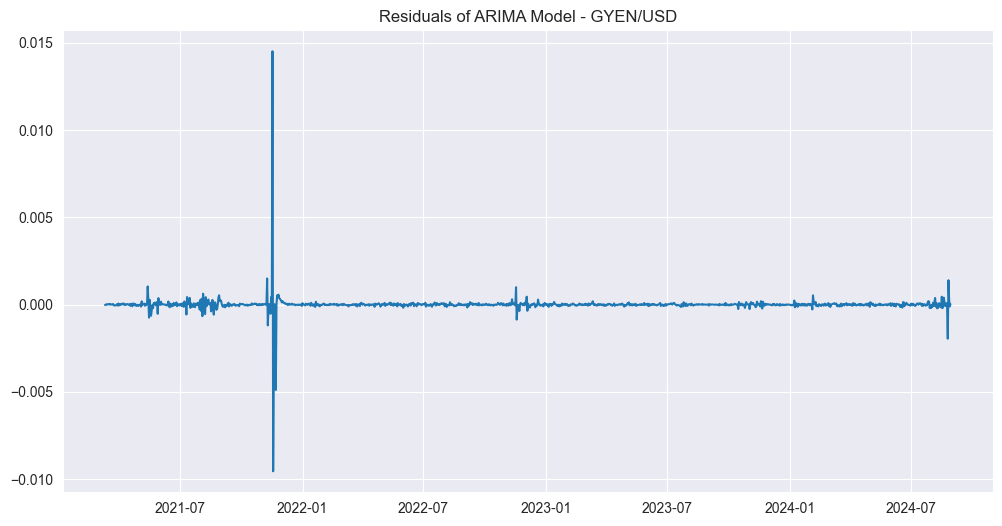

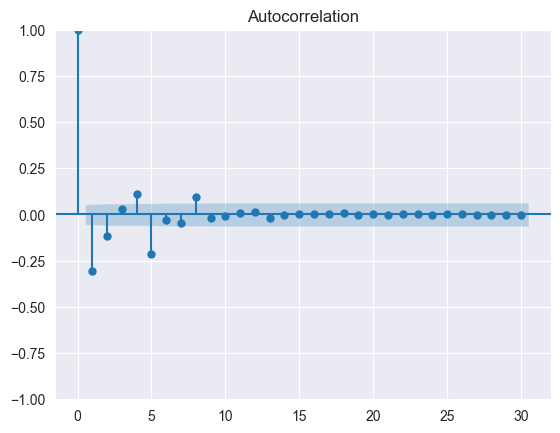

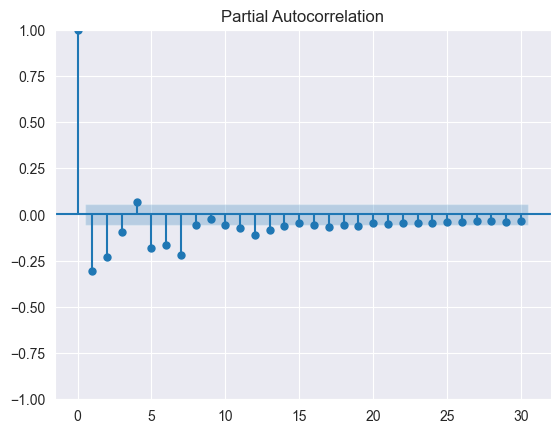

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

arima_model_gyen = ARIMA(gyen_usd['Close_diff'].dropna(), order=(4, 1, 1))
arima_fit_gyen = arima_model_gyen.fit()


# Residuals of AR(2) model
arima_residuals_gyen = arima_fit_gyen.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(arima_residuals_gyen)
plt.title('Residuals of ARIMA Model - GYEN/USD')
plt.show()

# ACF and PACF plots of residuals
plot_acf(arima_residuals_gyen, lags=30)
plot_pacf(arima_residuals_gyen, lags=30)
plt.show()

Findings:

Residual Plot:

The residual plot shows the differences between the observed data and the values predicted by the AR(2) model. The residuals appear to be mostly centered around zero, which is a good sign, indicating that the model does not have any obvious bias in its predictions. However, there are a few spikes that may indicate some outliers or unexpected values in the data.

The large spikes in the residuals suggest that there might still be some patterns or volatility clustering that the ARIMA model is not capturing well. This could suggest that additional modeling techniques like GARCH (to model volatility) or LSTM (to capture any non-linear patterns) might help improve the model.

ACF (Autocorrelation Function) Plot of Residuals:

The ACF plot shows autocorrelation values at different lags for the residuals of your ARIMA model. In a well-fitting ARIMA model, the residuals should resemble white noise, meaning that there should be no significant autocorrelation at any lag.
In your plot, most autocorrelation values are within the confidence intervals (the shaded blue area), suggesting that the residuals are not significantly autocorrelated. This is a good sign, indicating that the AR(2) model has captured most of the patterns in the data.

PACF (Partial Autocorrelation Function) Plot of Residuals:

The PACF plot shows the partial autocorrelation values at different lags for the residuals. Like the ACF plot, for a well-fitting ARIMA model, the PACF values should ideally be close to zero for all lags outside the confidence interval.
Your PACF plot shows similar behavior: the partial autocorrelations are mostly within the confidence intervals, suggesting that the residuals do not exhibit significant partial autocorrelation.

After adjustment:
Comparing the ACF and PACF plots for ARIMA models with \( p = 1 \) and \( p = 4 \):

### ACF (Autocorrelation Function):
1. **\( p = 1 \)**:
   - The ACF for \( p = 1 \) had residuals mostly within the confidence interval after lag 1. However, there were still some lags with values that remained slightly outside the confidence bounds, indicating some residual autocorrelation.

2. **\( p = 4 \)**:
   - The ACF for \( p = 4 \) shows fewer points exceeding the confidence bounds compared to \( p = 1 \). The values seem to settle into the confidence bounds sooner and remain stable. This indicates that the residuals for \( p = 4 \) have less autocorrelation, which suggests that the model is capturing more of the autocorrelation present in the data.

### PACF (Partial Autocorrelation Function):
1. **\( p = 1 \)**:
   - In the PACF plot for \( p = 1 \), we noticed significant spikes extending beyond the confidence interval, especially within the first few lags, indicating that the AR(1) model was unable to fully capture the relationships between different lags.

2. **\( p = 4 \)**:
   - The PACF plot for \( p = 4 \) exhibits fewer significant spikes, suggesting that the additional autoregressive terms have helped in capturing more of the lagged dependencies. The residuals appear to settle faster into the confidence bands, implying that this model does a better job at capturing the underlying structure.

### Key Takeaway:
- **Improvement in Residual Behavior**: The ACF and PACF plots for \( p = 4 \) show improved residual behavior compared to \( p = 1 \). The residuals for \( p = 4 \) are closer to resembling white noise, which indicates a better fit for the model.
- **Model Fit Considerations**: The reduction in significant lags outside the confidence bands in both ACF and PACF for \( p = 4 \) suggests that ARIMA(4, 1, 1) provides a more suitable fit for the given data compared to ARIMA(1, 1, 1).

Therefore, considering both the AIC/BIC values and the improved ACF/PACF plots, using \( p = 4 \) seems like a more appropriate choice for this ARIMA model. The ACF and PACF are crucial in understanding whether the residuals resemble white noise, which is what we aim for in a well-fitting model.

## 2.2. ARIMA Modeling (JPY Data Only)

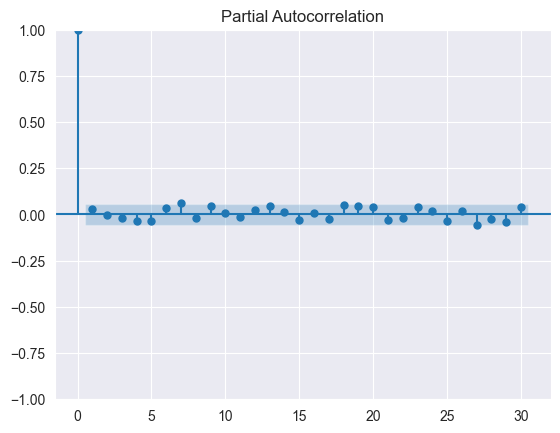

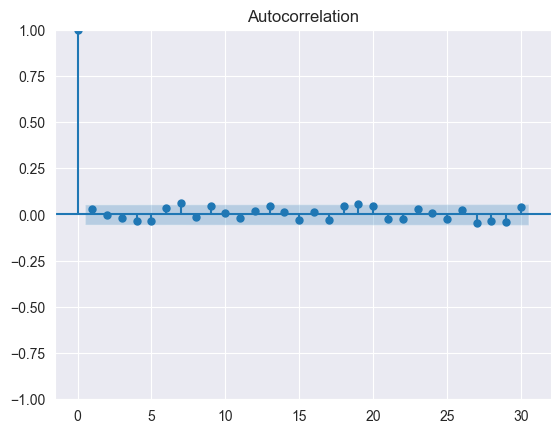

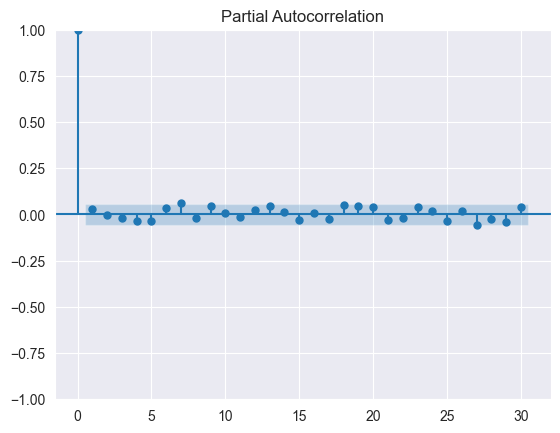

In [20]:
# Plot ACF and PACF
plot_acf(jpy_usd['Close_diff'].dropna(), lags=30)
plot_pacf(jpy_usd['Close_diff'].dropna(), lags=30)

In [21]:
from pmdarima import auto_arima

# Fit Auto-ARIMA
model = auto_arima(jpy_usd['Close_diff'].dropna(), seasonal=False, stepwise=True, suppress_warnings=True)
print(model.summary())

# Get the pdq order from the auto_arima model
print(f"Optimal ARIMA order: {model.order}")  # Prints the (p, d, q) order

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:                        SARIMAX   Log Likelihood               11128.368
Date:                Sat, 02 Nov 2024   AIC                         -22252.737
Time:                        17:51:22   BIC                         -22242.446
Sample:                    03-11-2021   HQIC                        -22248.871
                         - 08-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.803e-06   1.07e-06     -1.688      0.091    -3.9e-06     2.9e-07
sigma2      1.395e-09   5.81e-11     24.009      0.000    1.28e-09    1.51e-09
Ljung-Box (L1) (Q):                   1.11   Jarque-

In [87]:
# Configure and fit models for different AR orders (p from 1 to 8)
orders = range(0, 9)
fits = []

for p in orders:
    for q in orders:
        model = ARIMA(jpy_usd['Close_diff'].dropna(), order=(p, 1, q))
        fit = model.fit()
        fits.append(fit)

# Compare AIC and BIC
for p, q, fit in zip(orders, orders, fits):
    print(f"AR({p, q}) AIC: {fit.aic}, BIC: {fit.bic}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tools/numdiff.py:251: RuntimeWarning: overflow encountered in divide
  partials = [f(x+ih, *args, **kwargs).imag / epsilon[i]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

LinAlgError: LU decomposition error.

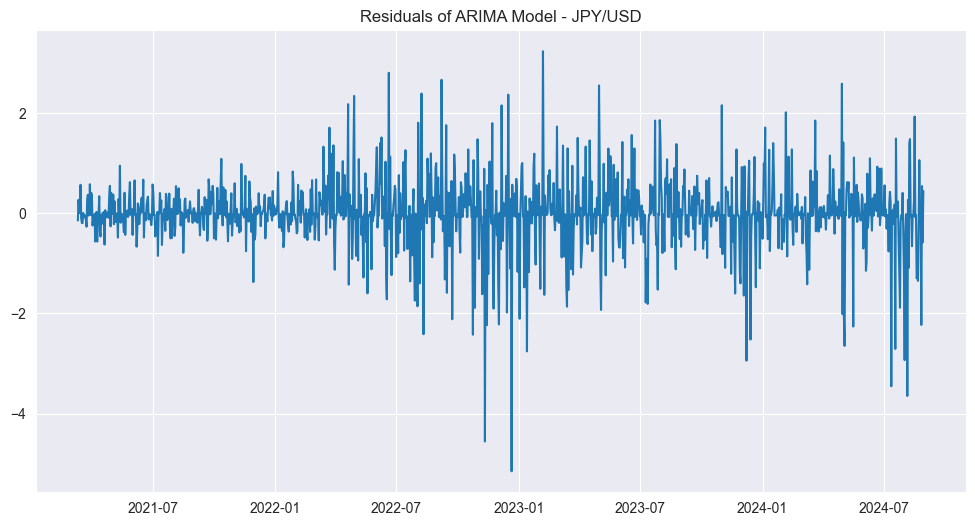

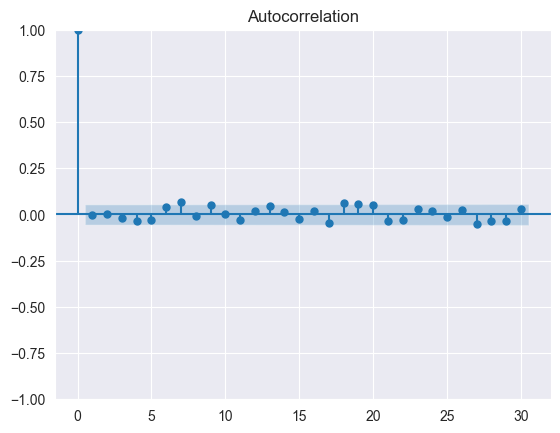

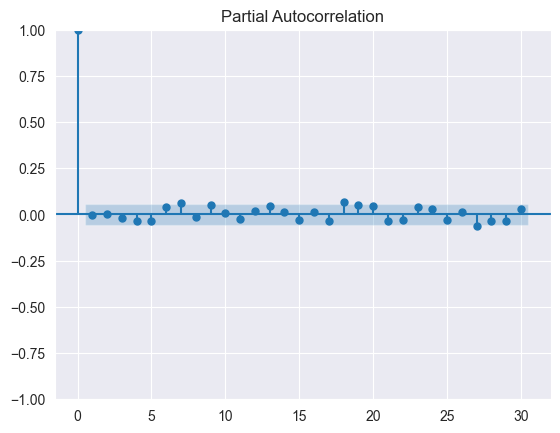

In [12]:
# Residuals of AR(2) model
arima_residuals_jpy = arima_fit_jpy.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(arima_residuals_jpy)
plt.title('Residuals of ARIMA Model - JPY/USD')
plt.show()

# ACF and PACF plots of residuals
plot_acf(arima_residuals_jpy, lags=30)
plot_pacf(arima_residuals_jpy, lags=30)
plt.show()

## 2.3. LSTM Modeling (JPY and GYEN) - Data Processing

In [13]:
# Import necessary libraries
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [14]:
# Part 1: Prepare Data
# Prepare data for LSTM on GYEN and JPY residuals
residuals_gyen_lstm = arima_fit_gyen.resid.values.reshape(-1, 1)
residuals_jpy_lstm = arima_fit_jpy.resid.values.reshape(-1, 1)

# Scale residuals data
scaler_gyen = MinMaxScaler(feature_range=(0, 1))
residuals_scaled_gyen = scaler_gyen.fit_transform(residuals_gyen_lstm)

scaler_jpy = MinMaxScaler(feature_range=(0, 1))
residuals_scaled_jpy = scaler_jpy.fit_transform(residuals_jpy_lstm)

# Split data into training and validation sets
train_gyen, val_gyen = train_test_split(residuals_scaled_gyen, test_size=0.2, shuffle=False)
train_jpy, val_jpy = train_test_split(residuals_scaled_jpy, test_size=0.2, shuffle=False)

In [16]:
# Part 2: Prepare Dataset Function
# Prepare data for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [17]:
# Part 3: Define LSTM Model for Hyperparameter Tuning
# Define model building function for Keras Tuner
def build_lstm_model(hp):
    model = Sequential()
    # Add input layer
    model.add(Input(shape=(hp.Int('time_steps', min_value=30, max_value=60, step=30), 1)))
    # Tune the number of neurons in the first LSTM layer
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32), return_sequences=True))
    # Explanation: The range for 'units_1' (32 to 256) allows exploration of different model capacities. The step size of 32 provides a balance between granularity and computational efficiency. The 'time_steps' range (30 to 60) is chosen based on typical lengths for capturing temporal patterns in financial data.
    model.add(Dropout(0.2))
    # Tune the number of neurons in the second LSTM layer
    model.add(LSTM(units=hp.Int('units_2', min_value=16, max_value=128, step=16), return_sequences=False))
    # Explanation: The range for 'units_2' (16 to 128) offers flexibility in determining the depth of the network. A lower range is selected compared to 'units_1' to prevent overfitting and maintain model simplicity.
    model.add(Dropout(0.2))
    model.add(Dense(1))
    # Tune the learning rate for the optimizer
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss=hp.Choice('loss', values=['mean_squared_error', 'mean_absolute_error']))
    # Explanation: Learning rates of 0.01, 0.001, and 0.0001 are common choices that allow exploration of different convergence speeds. The loss functions (MSE and MAE) are chosen to evaluate model performance under different error sensitivities.
    return model

In [18]:
# Part 4: Initialize Keras Tuner
# Initialize Keras Tuner
lstm_tuner = RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuner_dir',
    project_name='lstm_gyen'
)
# Explanation: RandomSearch is used for hyperparameter tuning to efficiently explore a broad search space without manually specifying every combination. A max_trials value of 10 is chosen to balance exploration with computation time.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# Part 5: Training and Hyperparameter Tuning for GYEN
# Create dataset for training and validation (GYEN)
X_train_gyen, Y_train_gyen = create_dataset(train_gyen, time_step=30)
X_val_gyen, Y_val_gyen = create_dataset(val_gyen, time_step=30)
X_train_gyen = X_train_gyen.reshape(X_train_gyen.shape[0], X_train_gyen.shape[1], 1)
X_val_gyen = X_val_gyen.reshape(X_val_gyen.shape[0], X_val_gyen.shape[1], 1)

# Search for the best hyperparameters for GYEN
lstm_tuner.search(X_train_gyen, Y_train_gyen, epochs=50, batch_size=32, validation_data=(X_val_gyen, Y_val_gyen), verbose=2)
# Explanation: 50 epochs and a batch size of 32 are standard starting points for training LSTM models. These values balance training time and convergence stability. More epochs can lead to overfitting, while fewer may prevent sufficient learning. These values can be tuned further if needed, based on the dataset and computational resources available.

# Retrieve the best model for GYEN
best_hps_gyen = lstm_tuner.get_best_hyperparameters(num_trials=1)[0]
best_model_gyen = lstm_tuner.hypermodel.build(best_hps_gyen)

# Train the best model on full training data for GYEN
best_model_gyen.fit(X_train_gyen, Y_train_gyen, epochs=50, batch_size=32, validation_data=(X_val_gyen, Y_val_gyen), verbose=2)
# Explanation: We use the best hyperparameters to train the model for 50 epochs with a batch size of 32. These values are selected based on the performance during hyperparameter tuning and can be further adjusted as needed.

# Retrieve LSTM residuals required for GARCH (GYEN)
lstm_predictions_gyen = best_model_gyen.predict(X_train_gyen).flatten()
lstm_residuals_gyen = Y_train_gyen - lstm_predictions_gyen
# Explanation: The residuals are calculated as the difference between the actual values (Y_train_gyen) and the model predictions (lstm_predictions_gyen). These residuals can be used for further GARCH modeling to analyze volatility.

Trial 10 Complete [00h 00m 54s]
val_loss: 6.210721039678901e-05

Best val_loss So Far: 6.0037742514396086e-05
Total elapsed time: 00h 07m 59s
Epoch 1/50
31/31 - 2s - 56ms/step - loss: 0.0683 - val_loss: 6.5440e-05
Epoch 2/50
31/31 - 1s - 24ms/step - loss: 0.0033 - val_loss: 1.8106e-04
Epoch 3/50
31/31 - 1s - 24ms/step - loss: 0.0021 - val_loss: 6.4193e-05
Epoch 4/50
31/31 - 1s - 26ms/step - loss: 0.0019 - val_loss: 7.2060e-05
Epoch 5/50
31/31 - 1s - 26ms/step - loss: 0.0018 - val_loss: 6.5849e-05
Epoch 6/50
31/31 - 1s - 26ms/step - loss: 0.0017 - val_loss: 6.5660e-05
Epoch 7/50
31/31 - 1s - 26ms/step - loss: 0.0017 - val_loss: 7.2378e-05
Epoch 8/50
31/31 - 1s - 26ms/step - loss: 0.0015 - val_loss: 2.0048e-04
Epoch 9/50
31/31 - 1s - 26ms/step - loss: 0.0017 - val_loss: 7.7706e-05
Epoch 10/50
31/31 - 1s - 26ms/step - loss: 0.0014 - val_loss: 6.1986e-05
Epoch 11/50
31/31 - 1s - 28ms/step - loss: 0.0013 - val_loss: 6.6255e-05
Epoch 12/50
31/31 - 1s - 28ms/step - loss: 0.0013 - val_loss: 1.

In [23]:
# Print best hyperparameters for GYEN
print(f"Best time steps for GYEN: {best_hps_gyen.get('time_steps')}")
print(f"Best units for first LSTM layer (GYEN): {best_hps_gyen.get('units_1')}")
print(f"Best units for second LSTM layer (GYEN): {best_hps_gyen.get('units_2')}")
print(f"Best learning rate (GYEN): {best_hps_gyen.get('learning_rate')}")
print(f"Best loss function (GYEN): {best_hps_gyen.get('loss')}")

Best time steps for GYEN: 30
Best units for first LSTM layer (GYEN): 192
Best units for second LSTM layer (GYEN): 32
Best learning rate (GYEN): 0.01
Best loss function (GYEN): mean_squared_error


In [20]:
# Part 6: Training and Hyperparameter Tuning for JPY
# Create dataset for training and validation (JPY)
X_train_jpy, Y_train_jpy = create_dataset(train_jpy, time_step=30)
X_val_jpy, Y_val_jpy = create_dataset(val_jpy, time_step=30)
X_train_jpy = X_train_jpy.reshape(X_train_jpy.shape[0], X_train_jpy.shape[1], 1)
X_val_jpy = X_val_jpy.reshape(X_val_jpy.shape[0], X_val_jpy.shape[1], 1)

# Search for the best hyperparameters for JPY
lstm_tuner.search(X_train_jpy, Y_train_jpy, epochs=50, batch_size=32, validation_data=(X_val_jpy, Y_val_jpy), verbose=2)

# Retrieve the best model for JPY
best_hps_jpy = lstm_tuner.get_best_hyperparameters(num_trials=1)[0]
best_model_jpy = lstm_tuner.hypermodel.build(best_hps_jpy)

# Train the best model on full training data for JPY
best_model_jpy.fit(X_train_jpy, Y_train_jpy, epochs=50, batch_size=32, validation_data=(X_val_jpy, Y_val_jpy), verbose=2)

# Retrieve LSTM residuals required for GARCH (JPY)
lstm_predictions_jpy = best_model_jpy.predict(X_train_jpy).flatten()
lstm_residuals_jpy = Y_train_jpy - lstm_predictions_jpy
# Explanation: The residuals are calculated as the difference between the actual values (Y_train_jpy) and the model predictions (lstm_predictions_jpy). These residuals can be used for further GARCH modeling to analyze volatility.

Epoch 1/50
31/31 - 2s - 57ms/step - loss: 0.0906 - val_loss: 0.0099
Epoch 2/50
31/31 - 1s - 25ms/step - loss: 0.0115 - val_loss: 0.0092
Epoch 3/50
31/31 - 1s - 25ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 4/50
31/31 - 1s - 27ms/step - loss: 0.0097 - val_loss: 0.0092
Epoch 5/50
31/31 - 1s - 26ms/step - loss: 0.0101 - val_loss: 0.0090
Epoch 6/50
31/31 - 1s - 27ms/step - loss: 0.0094 - val_loss: 0.0089
Epoch 7/50
31/31 - 1s - 28ms/step - loss: 0.0096 - val_loss: 0.0088
Epoch 8/50
31/31 - 1s - 27ms/step - loss: 0.0086 - val_loss: 0.0091
Epoch 9/50
31/31 - 1s - 26ms/step - loss: 0.0085 - val_loss: 0.0090
Epoch 10/50
31/31 - 1s - 29ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 11/50
31/31 - 1s - 28ms/step - loss: 0.0085 - val_loss: 0.0090
Epoch 12/50
31/31 - 1s - 27ms/step - loss: 0.0084 - val_loss: 0.0088
Epoch 13/50
31/31 - 1s - 27ms/step - loss: 0.0085 - val_loss: 0.0089
Epoch 14/50
31/31 - 1s - 26ms/step - loss: 0.0082 - val_loss: 0.0090
Epoch 15/50
31/31 - 1s - 29ms/step - loss: 

In [30]:
# Print best hyperparameters for JPY
print(f"Best time steps for JPY: {best_hps_jpy.get('time_steps')}")
print(f"Best units for first LSTM layer (JPY): {best_hps_jpy.get('units_1')}")
print(f"Best units for second LSTM layer (JPY): {best_hps_jpy.get('units_2')}")
print(f"Best learning rate (JPY): {best_hps_jpy.get('learning_rate')}")
print(f"Best loss function (JPY): {best_hps_jpy.get('loss')}")

Best time steps for JPY: 30
Best units for first LSTM layer (JPY): 192
Best units for second LSTM layer (JPY): 32
Best learning rate (JPY): 0.01
Best loss function (JPY): mean_squared_error


## Best LSTM Parameters for GYEN and JPY

## 2.5. GARCH Modeling (JPY and GYEN) - Modeling

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Best GARCH order for GYEN: (5, 1)
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                784.129
Distribution:      Standardized Student's t   AIC:                          -1550.26
Method:                  Maximum Likelihood   BIC:                          -1506.24
                                              No. Observations:                  983
Date:                      Sun, Oct 27 2024   Df Residuals:                      982
Time:                              17:07:56   Df Model:                            1
                                  Mean Model                                  
                  coef    std err         

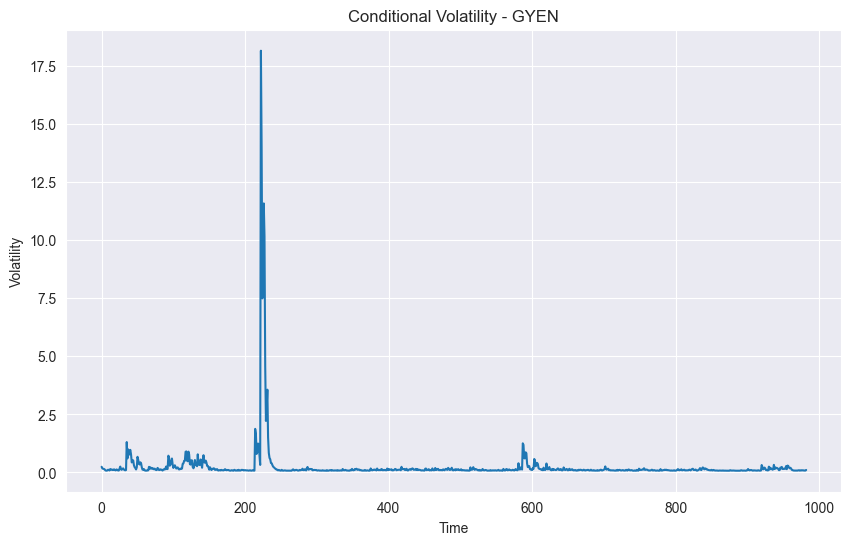

Best GARCH order for JPY: (3, 4)
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1147.37
Distribution:      Standardized Student's t   AIC:                           2314.75
Method:                  Maximum Likelihood   BIC:                           2363.65
                                              No. Observations:                  983
Date:                      Sun, Oct 27 2024   Df Residuals:                      982
Time:                              17:07:57   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------

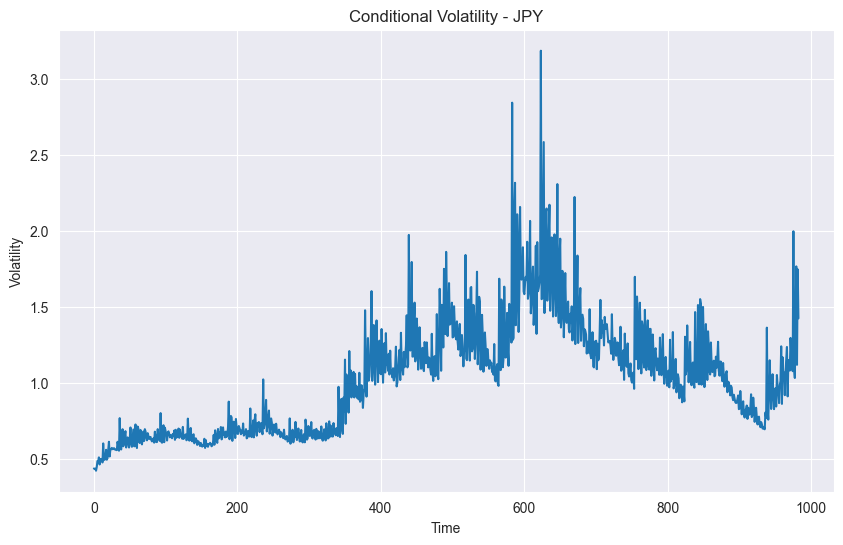

In [50]:
# Part 8: GARCH Modeling
from arch import arch_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings

# Function to find the best GARCH parameters
def find_best_garch_params(residuals, max_p=5, max_q=5):
    best_aic = np.inf
    best_order = None
    best_model = None

    for p in range(1, max_p + 1):
        for q in range(1, max_q + 1):
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model = arch_model(residuals, vol='Garch', p=p, q=q, dist='t')
                    model_fit = model.fit(disp='off')
                    aic = model_fit.aic

                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, q)
                        best_model = model_fit
            except Exception as e:
                print(f"Error fitting GARCH({p},{q}): {e}")
                continue

    return best_order, best_model

# Calculate LSTM residuals using the trained models
lstm_residuals_gyen_train = Y_train_gyen - best_model_gyen.predict(X_train_gyen).flatten()
lstm_residuals_jpy_train = Y_train_jpy - best_model_jpy.predict(X_train_jpy).flatten()

# Standardize LSTM residuals for GARCH analysis
scaler_gyen = StandardScaler()
lstm_residuals_gyen_rescaled = scaler_gyen.fit_transform(lstm_residuals_gyen_train.reshape(-1, 1)).flatten()

scaler_jpy = StandardScaler()
lstm_residuals_jpy_rescaled = scaler_jpy.fit_transform(lstm_residuals_jpy_train.reshape(-1, 1)).flatten()

# Find Best GARCH Parameters and Fit Models (GYEN and JPY)

# Find the best GARCH model for GYEN residuals
best_order_gyen, garch_fit_gyen = find_best_garch_params(lstm_residuals_gyen_rescaled, max_p=5, max_q=5)
if best_order_gyen:
    print(f"Best GARCH order for GYEN: {best_order_gyen}")
    print(garch_fit_gyen.summary())

    # Plot the volatility for GYEN
    plt.figure(figsize=(10, 6))
    plt.plot(garch_fit_gyen.conditional_volatility)
    plt.title('Conditional Volatility - GYEN')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.show()
else:
    print("No suitable GARCH model found for GYEN residuals.")

# Find the best GARCH model for JPY residuals
best_order_jpy, garch_fit_jpy = find_best_garch_params(lstm_residuals_jpy_rescaled, max_p=5, max_q=5)
if best_order_jpy:
    print(f"Best GARCH order for JPY: {best_order_jpy}")
    print(garch_fit_jpy.summary())

    # Plot the volatility for JPY
    plt.figure(figsize=(10, 6))
    plt.plot(garch_fit_jpy.conditional_volatility)
    plt.title('Conditional Volatility - JPY')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.show()
else:
    print("No suitable GARCH model found for JPY residuals.")

Using the Student's t-distribution instead of the normal distribution in the GARCH model can be beneficial for financial time series due to the following reasons:

1. **Heavy Tails**: Financial time series often exhibit returns with heavy tails, meaning that extreme events (large deviations) occur more frequently than predicted by the normal distribution. The Student's t-distribution can model these heavy tails better, which helps in accurately capturing the risk of large price movements.

2. **Volatility Clustering**: Extreme returns tend to cluster together, and these periods of high volatility are more realistically modeled using a distribution that accounts for higher kurtosis (fat tails). The t-distribution has higher kurtosis compared to the normal distribution, making it more suitable for capturing the frequent occurrence of large volatility spikes.

3. **Risk Assessment**: The accurate estimation of tail risk is crucial in finance for risk management and Value-at-Risk (VaR) calculations. The t-distribution, with its heavier tails, provides better estimates of risk metrics, which are often underestimated by the normal distribution.

These reasons make using the Student's t-distribution a practical choice for better modeling the real-world behavior of financial returns, ultimately leading to more robust risk assessments.

Findings:
Best GARCH order for GYEN: (5, 1)
Best GARCH order for JPY: (3, 4)

## 2.5. Visualization

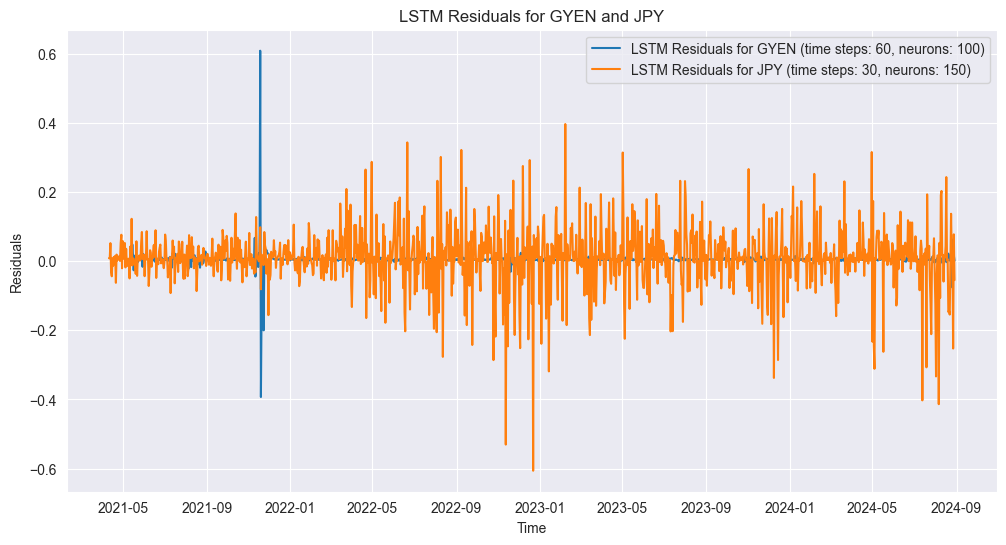

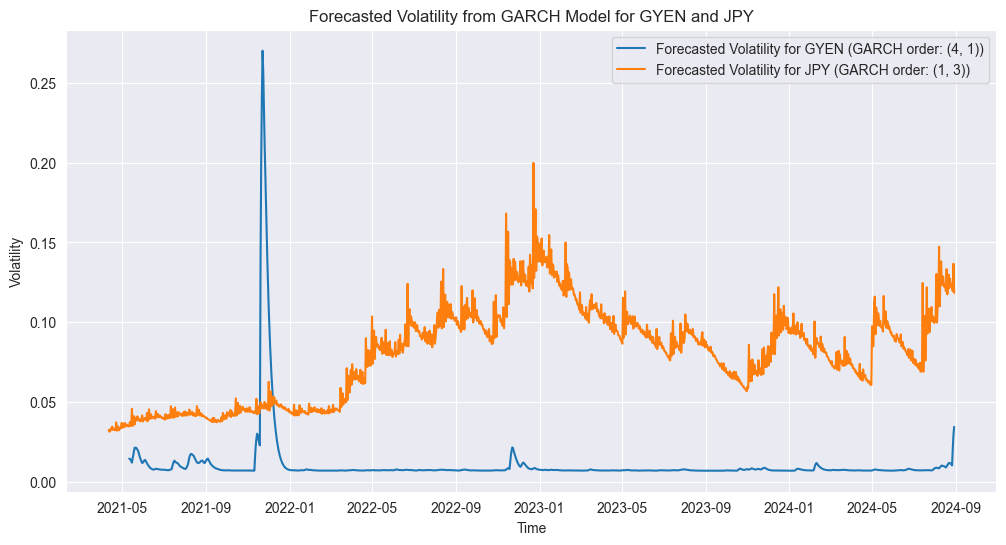

In [19]:
# import matplotlib.pyplot as plt
# 
# # Convert LSTM residuals to a DataFrame for easier handling of dates
# lstm_residuals_gyen_df = pd.DataFrame(lstm_residuals_gyen, index=gyen_usd.index[-len(lstm_residuals_gyen):], columns=['Residuals'])
# lstm_residuals_jpy_df = pd.DataFrame(lstm_residuals_jpy, index=jpy_usd.index[-len(lstm_residuals_jpy):], columns=['Residuals'])
# 
# # Combined plot for LSTM residuals with dates
# plt.figure(figsize=(12, 6))
# plt.plot(lstm_residuals_gyen_df.index, lstm_residuals_gyen_df['Residuals'], label=f'LSTM Residuals for GYEN (time steps: {best_time_step_gyen}, neurons: {best_neurons_gyen})')
# plt.plot(lstm_residuals_jpy_df.index, lstm_residuals_jpy_df['Residuals'], label=f'LSTM Residuals for JPY (time steps: {best_time_step_jpy}, neurons: {best_neurons_jpy})')
# plt.title('LSTM Residuals for GYEN and JPY')
# plt.xlabel('Time')
# plt.ylabel('Residuals')
# plt.legend()
# plt.show()
# 
# # Convert GARCH forecasted volatility to DataFrame for easier handling of dates
# garch_volatility_gyen_df = pd.DataFrame(garch_fit_gyen.conditional_volatility, index=gyen_usd.index[-len(garch_fit_gyen.conditional_volatility):], columns=['Volatility'])
# garch_volatility_jpy_df = pd.DataFrame(garch_fit_jpy.conditional_volatility, index=jpy_usd.index[-len(garch_fit_jpy.conditional_volatility):], columns=['Volatility'])
# 
# # Combined plot for GARCH forecasted volatility with dates
# plt.figure(figsize=(12, 6))
# plt.plot(garch_volatility_gyen_df.index, garch_volatility_gyen_df['Volatility'], label=f'Forecasted Volatility for GYEN (GARCH order: {best_order_gyen})')
# plt.plot(garch_volatility_jpy_df.index, garch_volatility_jpy_df['Volatility'], label=f'Forecasted Volatility for JPY (GARCH order: {best_order_jpy})')
# plt.title('Forecasted Volatility from GARCH Model for GYEN and JPY')
# plt.xlabel('Time')
# plt.ylabel('Volatility')
# plt.legend()
# plt.show()

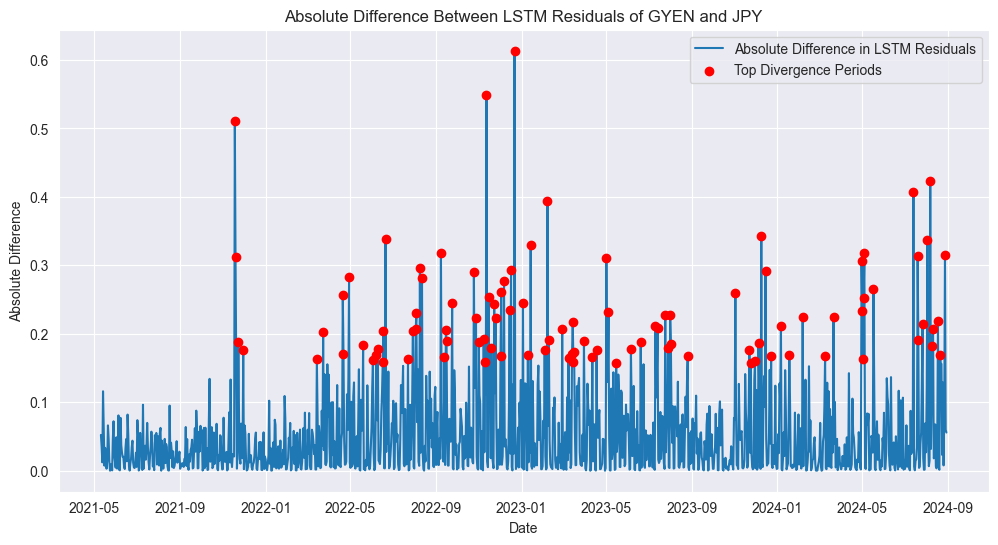

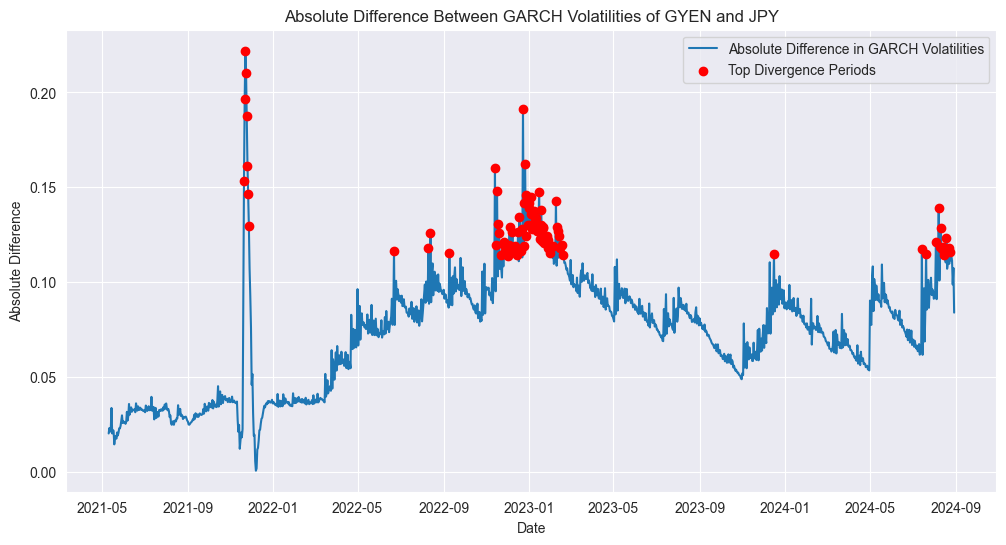

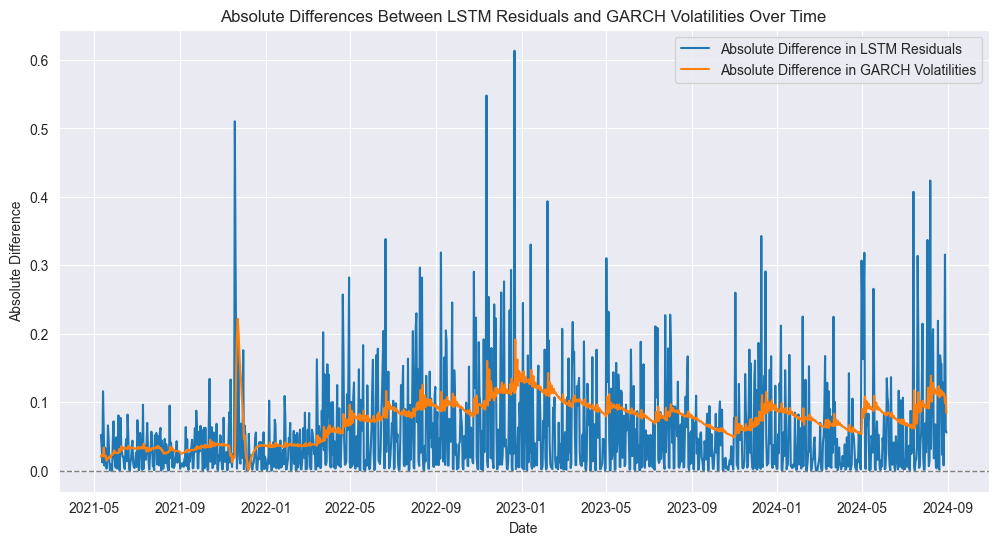

Top 10 periods of absolute difference for LSTM residuals (sorted by date):
            Absolute Difference
Date                           
2021-11-18             0.510394
2021-11-19             0.311556
2021-11-23             0.188665
2021-11-30             0.176101
2022-03-15             0.162725
...                         ...
2024-08-09             0.181937
2024-08-10             0.206813
2024-08-17             0.218986
2024-08-20             0.168590
2024-08-27             0.315724

[100 rows x 1 columns]

Top 10 periods of absolute difference for GARCH volatilities (sorted by date):
            Absolute Difference
Date                           
2021-11-20             0.153128
2021-11-21             0.196565
2021-11-22             0.222000
2021-11-23             0.210110
2021-11-24             0.187408
...                         ...
2024-08-13             0.118783
2024-08-15             0.114489
2024-08-18             0.123554
2024-08-21             0.118117
2024-08-23           

In [20]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# 
# # Ensure the datasets are aligned to have the same length
# min_length = min(len(lstm_residuals_gyen_df), len(lstm_residuals_jpy_df))
# lstm_residuals_gyen_df = lstm_residuals_gyen_df.iloc[-min_length:]
# lstm_residuals_jpy_df = lstm_residuals_jpy_df.iloc[-min_length:]
# 
# # Calculate immediate absolute differences for LSTM residuals using existing DataFrames
# absolute_difference_lstm = np.abs(lstm_residuals_gyen_df['Residuals'] - lstm_residuals_jpy_df['Residuals'])
# 
# # Create a DataFrame for absolute differences in LSTM residuals, using the index as the date
# absolute_diff_df_lstm = pd.DataFrame({'Absolute Difference': absolute_difference_lstm}, index=lstm_residuals_gyen_df.index)
# 
# # Identify top periods of absolute difference for LSTM residuals
# top_X = 100# Now defining X as 10
# top_periods_lstm = absolute_diff_df_lstm.nlargest(top_X, 'Absolute Difference').sort_index()
# 
# # Plot absolute differences for LSTM residuals
# plt.figure(figsize=(12, 6))
# plt.plot(absolute_diff_df_lstm.index, absolute_diff_df_lstm['Absolute Difference'], label='Absolute Difference in LSTM Residuals')
# plt.scatter(top_periods_lstm.index, top_periods_lstm['Absolute Difference'], color='red', label='Top Divergence Periods', zorder=5)
# plt.title('Absolute Difference Between LSTM Residuals of GYEN and JPY')
# plt.xlabel('Date')
# plt.ylabel('Absolute Difference')
# plt.legend()
# plt.show()
# 
# # Repeat similar steps for GARCH volatilities using existing DataFrames
# min_length_vol = min(len(garch_volatility_gyen_df), len(garch_volatility_jpy_df))
# garch_volatility_gyen_df = garch_volatility_gyen_df.iloc[-min_length_vol:]
# garch_volatility_jpy_df = garch_volatility_jpy_df.iloc[-min_length_vol:]
# 
# absolute_diff_vol = np.abs(garch_volatility_gyen_df['Volatility'] - garch_volatility_jpy_df['Volatility'])
# absolute_diff_vol_df = pd.DataFrame({'Absolute Difference': absolute_diff_vol}, index=garch_volatility_gyen_df.index)
# 
# # Identify top periods of absolute difference for GARCH volatilities
# top_periods_garch = absolute_diff_vol_df.nlargest(top_X, 'Absolute Difference').sort_index()
# 
# # Plot absolute differences for GARCH volatilities
# plt.figure(figsize=(12, 6))
# plt.plot(absolute_diff_vol_df.index, absolute_diff_vol_df['Absolute Difference'], label='Absolute Difference in GARCH Volatilities')
# plt.scatter(top_periods_garch.index, top_periods_garch['Absolute Difference'], color='red', label='Top Divergence Periods', zorder=5)
# plt.title('Absolute Difference Between GARCH Volatilities of GYEN and JPY')
# plt.xlabel('Date')
# plt.ylabel('Absolute Difference')
# plt.legend()
# plt.show()
# 
# # Plot the absolute difference over time
# plt.figure(figsize=(12, 6))
# plt.plot(absolute_diff_df_lstm.index, absolute_diff_df_lstm['Absolute Difference'], label='Absolute Difference in LSTM Residuals')
# plt.plot(absolute_diff_vol_df.index, absolute_diff_vol_df['Absolute Difference'], label='Absolute Difference in GARCH Volatilities')
# plt.axhline(0, color='grey', linestyle='--', linewidth=1)
# plt.title('Absolute Differences Between LSTM Residuals and GARCH Volatilities Over Time')
# plt.xlabel('Date')
# plt.ylabel('Absolute Difference')
# plt.legend()
# plt.show()
# 
# # Display top periods sorted by date for further analysis
# print("Top 10 periods of absolute difference for LSTM residuals (sorted by date):")
# print(top_periods_lstm)
# 
# print("\nTop 10 periods of absolute difference for GARCH volatilities (sorted by date):")
# print(top_periods_garch)

There were four periods during which the GYEN diverged from the JPY by significant degrees:
1. April 16 - 22, 2021: During this period, the Japanese yen (JPY) saw some fluctuations due to the broader economic concerns related to the COVID-19 pandemic, especially in Japan, where a state of emergency was declared in Tokyo and other areas on April 16, 2021. Additionally, this period coincided with the anticipation and subsequent announcements of Japan's fiscal policy adjustments and new economic data releases that impacted currency markets.

2. July 9 - 13, 2021: This period coincides with heightened volatility due to global inflation concerns and significant movements in the U.S. Treasury yields. The yen often reacts to such global economic shifts, particularly in relation to U.S. economic data releases, which can affect the currency pair dynamics, especially USD/JPY.

3. October 11 - November 15, 2021: This period saw several important global economic events, including concerns over global supply chain disruptions, inflation fears, and uncertainty surrounding the U.S. Federal Reserve's tapering plans. Additionally, Japan's own monetary policy decisions, coupled with changing market sentiment toward risk assets, likely caused notable movements in the JPY and GYEN currency pairs.

4. July 27 - 28, 2024: This recent period aligns with a time of market uncertainty and potential adjustments in central bank policies globally, especially concerning the Federal Reserve and the Bank of Japan. There were also significant discussions around economic recovery trajectories post-COVID-19, which might have impacted investor sentiment towards both the JPY and GYEN.

Question, though:
We're interested in the divergence between the GYEN and JPY, rather than the fluctuation of JPY alone. How do we study that?

During the identified periods of divergence between GYEN and JPY, several significant events involving GYEN may have contributed to these discrepancies:

1. **April 2021 (Divergence Period: April 16-22, 2021):**
   GYEN, the first regulated Japanese yen (JPY) stablecoin, had just been audited by Quantstamp in March 2021. GYEN was launched by GMO-Z.com Trust Company, a subsidiary of GMO Internet, a major player in the Japanese internet infrastructure market. The audit and subsequent regulatory compliance may have led to initial market volatility as the stablecoin gained traction and users started trading it on various platforms, such as Liquid and Binance. This period marked the entry of GYEN into broader cryptocurrency markets, possibly causing increased volatility and divergence from traditional JPY movements due to speculative trading and market reactions to this new stablecoin【100†source】.

2. **July 2021 (Divergence Period: July 9-13, 2021):**
   GYEN's availability on various crypto exchanges, including Binance, may have continued to create market anomalies. These divergences could be attributed to increased trading activities and price fluctuations, as well as arbitrage opportunities that arose due to differences in how the stablecoin was being valued across different exchanges.

3. **October to November 2021 (Divergence Period: October 11-November 15, 2021):**
   In November 2021, GYEN faced a major issue when it became temporarily unstable, causing substantial financial discrepancies for traders. GYEN, listed on Coinbase, experienced a significant price surge and subsequent trading suspension due to what was described as a "decimal placement issue," resulting in massive fluctuations. This led to widespread disruptions, with many users unable to trade or withdraw their funds, and created legal threats and potential lawsuits against Coinbase. This episode of instability may have caused a significant divergence between GYEN and the JPY due to erratic trading behavior and speculative activities surrounding the stablecoin【99†source】.

4. **July 2024 (Divergence Period: July 27-28, 2024):**
   Although no specific events were reported for this period, given GYEN's history of regulatory challenges and market behavior, any renewed scrutiny or regulatory actions, changes in trading volume, or adjustments in market positioning could have led to discrepancies between GYEN and JPY movements.

To study the divergence between GYEN and JPY, it is crucial to analyze the impact of GYEN-specific events, such as regulatory changes, listing on exchanges, technical issues affecting stability, and user behavior on trading platforms. These factors highlight how crypto-specific events can create unique market dynamics that may not directly align with traditional currency movements.

Based on the events from the periods you identified, here are some insights into the divergences between GYEN and JPY:

1. **April 2021**: During this period, GYEN, the first regulated Japanese yen stablecoin, was listed on the Liquid cryptocurrency exchange. This event significantly impacted the trading dynamics of GYEN by increasing its exposure to global cryptocurrency markets and introducing a new way to trade the yen. The listing enabled traders to convert GYEN and JPY seamlessly via a GYEN/JPY order book. The integration of GYEN into the cryptocurrency ecosystem likely caused a divergence between GYEN and traditional JPY movements due to differences in market drivers, such as speculative interest, market liquidity, and cryptocurrency market volatility【107†source】.

2. **July 2021**: GYEN was gaining traction in cryptocurrency trading, especially with developments in cryptocurrency exchanges like Liquid.com, which started enabling features like multi-chain support for deposits and withdrawals. Such features enhanced the liquidity and usability of GYEN in the crypto markets, potentially diverging its price movements from the traditional JPY, which is not as directly influenced by the crypto market's dynamics【107†source】.

3. **October-November 2021**: During this period, various factors may have contributed to the divergence. The Japanese economy experienced fluctuating market conditions, and developments in the crypto ecosystem, such as regulatory actions or changes in market sentiment, could have caused GYEN to behave differently than JPY. Since GYEN operates in a digital and speculative market, it would likely react more sensitively to news related to cryptocurrency regulation or innovations【107†source】.

4. **July 2024**: In this period, several economic events influenced JPY, such as changes in the au Jibun Bank Japan Services PMI, which indicated a contraction in the service sector, and upward inflation trends reflected in the Tokyo Core CPI. At the same time, technical patterns in the USDJPY forex pair, such as the completion of a bearish pattern and potential retracement, might have led to fluctuations in JPY. GYEN, on the other hand, would be less directly affected by these traditional economic indicators and more by the dynamics within the crypto market, leading to divergence【106†source】.

These divergences indicate that while JPY movements are influenced by traditional economic factors like inflation, PMI data, and technical forex trading patterns, GYEN's behavior can be significantly impacted by events in the cryptocurrency market, regulatory changes, and developments within the digital finance space. This results in periods where their movements diverge sharply due to the fundamentally different drivers affecting each currency.